# Evaluate the predictions made

In this notebook we use a winner-take-all decision to determine which type of language lateralization is suggested by the (relative) majority of a patient's 200 volumes. Then we determine the overall accuracy and compute confusion matrices to describe the pattern of correct classifications and confusions based on the WTA decisions.

### import modules

In [1]:
import pickle

import numpy as np
import pandas as pd

from sklearn import metrics, linear_model

from scipy import stats

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('poster')
sns.set_style('ticks')

### get meta df

We need this e.g. to get information about conclusiveness

In [3]:
data_df = pd.read_csv(
    '../data/processed/csv/info_epi_zscored_zdiff_summarymaps_2dpredclean_corr_counts_df.csv',
    index_col=[0, 1],
    header=0)

In [ ]:
data_df.tail()

### get the count data

In [5]:
def make_count_df(data_df,metric='counts_df'):
    
    count_df = pd.DataFrame()
    for p in data_df.index:

        filename = data_df.loc[p,metric]
        p_df = pd.read_csv(filename,index_col=[0,1])
        count_df = pd.concat([count_df,p_df])
        
    count_df = count_df.sort_index(axis=0)
    count_df = count_df.sort_index(axis=1)
    
    return count_df

### transform into proportions

In [6]:
proportion_df = make_count_df(data_df)/200.

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Highest number of agreeing volumes:

In [7]:
proportion_df.max().max()*200

171.0

In [ ]:
proportion_df.tail()

In [9]:
assert all(proportion_df.sum(axis=1).round(2)==1), 'proportions do not sum up to one!'

### assert that there are no draws

In [10]:
identify_draws = lambda x: x-proportion_df.max(axis=1)

In [11]:
draws_df = proportion_df.apply(identify_draws)

In [ ]:
draws_df.tail()

In [13]:
draws = (draws_df==0).sum(axis=1)!=1

In [ ]:
draws[draws]

#### Example

In [ ]:
p_group,p_name = proportion_df.index[-1]
p_name

In [ ]:
p_count_df = proportion_df.loc[[(p_group,p_name)]]
p_count_df

#### split into conclusive and inconclusive patients

In [17]:
is_conclusive = data_df.loc[:, 'pred'] != 'inconclusive'

In [18]:
# only conclusive cases
conclusive_proportion_df = proportion_df[is_conclusive]
# only inconclusive cases
inconclusive_proportion_df = proportion_df[is_conclusive == False]
# all cases unfiltered
withinconclusive_proportion_df = proportion_df.copy()

In [19]:
print(conclusive_proportion_df.shape,inconclusive_proportion_df.shape, withinconclusive_proportion_df.shape)

(63, 3) (33, 3) (96, 3)


Descriptive statistics

In [20]:
conclusive_proportion_df.groupby(level=0).aggregate(['count', 'mean', 'std']).round(2)

bilateral              left             right            
              count  mean   std count  mean   std count  mean   std
bilateral        10  0.33  0.07    10  0.31  0.12    10  0.36  0.12
left             39  0.23  0.07    39  0.53  0.11    39  0.24  0.08
right            14  0.26  0.09    14  0.24  0.10    14  0.51  0.16

In [21]:
inconclusive_proportion_df.groupby(level=0).aggregate(['count', 'mean', 'std']).round(2)

bilateral              left             right            
              count  mean   std count  mean   std count  mean   std
bilateral         4  0.33  0.05     4  0.30  0.12     4  0.37  0.07
left             20  0.28  0.05    20  0.33  0.06    20  0.39  0.06
right             9  0.30  0.08     9  0.29  0.04     9  0.41  0.06

### color settings

In [22]:
with open('../models/colors.p', 'rb') as f:
    color_dict = pickle.load(f)
    
my_cols = {}
for i, j in zip(['red', 'blue', 'yellow'], ['left', 'right', 'bilateral']):
    my_cols[j] = color_dict[i]

### plot preds

In [23]:
sns_df = withinconclusive_proportion_df.copy()
sns_df.index.names = ['true lateralization','id']
sns_df = pd.DataFrame(sns_df.stack())
sns_df.index.names = ['true lateralization','id','prediction']
sns_df.columns = ['proportion of agreeing volumes']
sns_df.loc[:,'true lateralization'] = sns_df.index.get_level_values(0)
sns_df.loc[:,'prediction'] = sns_df.index.get_level_values(2)

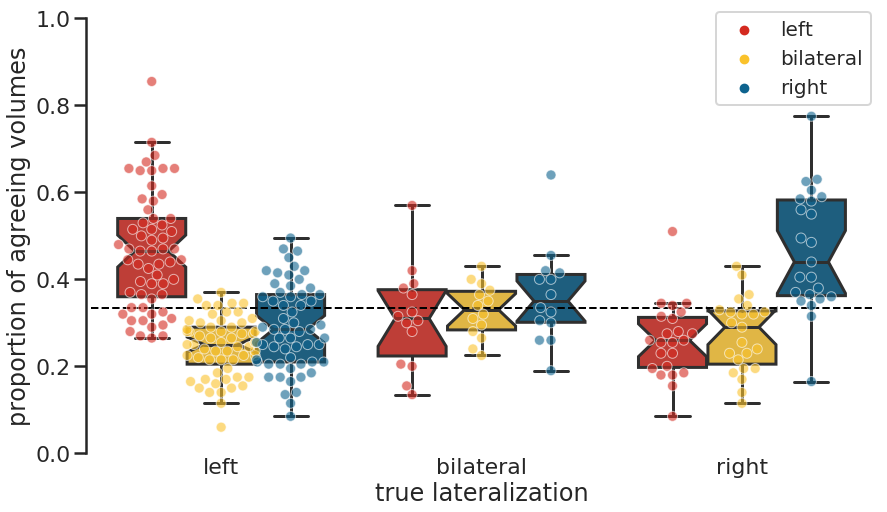

In [24]:
fig,ax = plt.subplots(1,1,figsize=(14,8))

sns.boxplot(
    data=sns_df,
    x='true lateralization',
    y='proportion of agreeing volumes',
    hue='prediction',
    #whis=0,
    fliersize=0,
    dodge=True,
    order=['left', 'bilateral', 'right'],
    hue_order=['left', 'bilateral', 'right'],
    palette=my_cols,
    notch=True,
    ax=ax)
sns.swarmplot(
    data=sns_df,
    x='true lateralization',
    y='proportion of agreeing volumes',
    hue='prediction',
    dodge=True,
    order=['left', 'bilateral', 'right'],
    hue_order=['left', 'bilateral', 'right'],
    size=10,
    edgecolor='white',
    linewidth=1,
    alpha=0.6,
    palette=my_cols,
    ax=ax)

ax.axhline(1/3,linewidth=2,linestyle='--',color='k')

ax.set_ylim(0,1)
handles,labels=ax.get_legend_handles_labels() 
ax.legend(handles[3:],labels[3:],loc=(0.8, 0.8), fontsize=20)
ax.tick_params(axis='x',length=0)
sns.despine(trim=True,offset=5,bottom=True)
plt.savefig('../reports/figures/13-swarmplot-descriptive.png',dpi=300,bbox_inches='tight')
plt.show()

### collect number of concordant volumes and WTA predictions

In [25]:
def make_metric_df(proportion_df, group_predict=None,group_true=None,draws=draws):

    metric_df = proportion_df.copy()
    metric_df.loc[:, 'highest_num'] = metric_df.max(axis=1)
    metric_df.loc[:, 'highest_class'] = metric_df.idxmax(axis=1)

    metric_df.loc[:,'true_class'] = metric_df.index.get_level_values(0)
    is_hit = (metric_df.loc[:, 'highest_class'] == metric_df.loc[:,'true_class'] )
    metric_df.loc[:, 'hit'] = is_hit

    if group_predict is not None:
        is_predict = (metric_df.loc[:, 'highest_class'] == group_predict)
        metric_df = metric_df[is_predict]

    if group_true is not None:
        is_true = (metric_df.loc[:, 'true_class'] == group_true)
        metric_df = metric_df[is_true]

    # if there was a draw, the prediction is false no matter what (conservative behavior)
    metric_df.loc[draws,'hit'] = False
    
    return metric_df

In [26]:
conclusive_prediction_df = make_metric_df(conclusive_proportion_df)

In [ ]:
conclusive_prediction_df.tail()

In [ ]:
conclusive_prediction_df.loc[draws,:]

In [29]:
conclusive_prediction_df['hit'].mean()

0.8412698412698413

### plot accuracy with increasing certainty threshold

In [30]:
def make_acc_df(metric_df):

    d = {}
    for threshold in np.linspace(1, 0, 201):
        is_bigger_or_equal = metric_df.loc[:, 'highest_num'] >= threshold
        filtered_df = metric_df[is_bigger_or_equal]
        n = filtered_df.shape[0]
        n_prop = np.max(float(n) / metric_df.shape[0], 0)
        acc = filtered_df.loc[:, 'hit'].mean()
        d[threshold] = {'acc': acc, 'n_prop': n_prop,'n':n}
    df = pd.DataFrame(d).T

    return df

In [31]:
df = make_acc_df(conclusive_prediction_df)

In [32]:
df.tail()

,acc,n,n_prop
0.020,0.84127,63.0,1.0
0.015,0.84127,63.0,1.0
0.010,0.84127,63.0,1.0
0.005,0.84127,63.0,1.0
0.000,0.84127,63.0,1.0


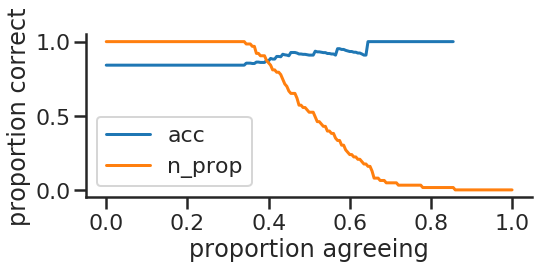

In [33]:
plt.figure(figsize=(8, 3))
for c in ['acc','n_prop']:
    plt.plot(df.loc[:, c], label=c)
plt.xlabel('proportion agreeing')
plt.ylabel('proportion correct')
plt.legend(loc='best')
sns.despine()
plt.show()

### evaluate the accuracy

In [34]:
def get_guessing_rate(df):
    n = df.shape[0]
    biggest_class = df.groupby(level=0).count().max().max()
    guessing_rate = float(biggest_class) / n
    return guessing_rate

In [35]:
conclusive_guessing_rate = get_guessing_rate(conclusive_prediction_df)
conclusive_guessing_rate

0.6190476190476191

#### function to get confidence intervals

In [36]:
def binom_interval(success, total, confint=0.95):
    #https://gist.github.com/paulgb/6627336
    quantile = (1 - confint) / 2.
    lower = stats.beta.ppf(quantile, success, total - success + 1)
    upper = stats.beta.ppf(1 - quantile, success + 1, total - success)
    return np.array([lower, upper])

In [37]:
def make_ci_df(metric_df):
    
    ci_df = make_acc_df(metric_df)
    for i in ci_df.index:
        acc = ci_df.loc[i,'acc']
        n = ci_df.loc[i,'n']
        #print(i,acc,n)
        ci = binom_interval((acc * n)*0.99999999, n)
        ci_df.loc[i,'ci_low'] = ci[0]
        ci_df.loc[i,'ci_high'] = ci[1]

    return ci_df

### One plot for all groups

In [38]:
def make_ci_plot(df, guessing_rate, color_dict=color_dict):

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    ax1.plot(
        df['acc'],
        c=color_dict['red'],
        label='acc',
        linewidth=7,
        alpha=0.9)

    ax1.fill_between(
        df.index,
        df['ci_low'],
        df['ci_high'].fillna(1),
        alpha=0.3,
        color=color_dict['red'])

    ax2.plot(
        df['n'],
        c=color_dict['blue'],
        label=u'n',
        linewidth=7,
        alpha=0.9)

    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('n remaining')
    ax2.set_ylim(0, df.loc[:, 'n'].max() * 1.01)
    ax1.set_xlabel('n agreeing volumes')
    ax1.legend(loc=(0.62, 0.6), fontsize=20)
    ax2.legend(loc=(0.62, 0.5), fontsize=20)

    ax1.axhline(guessing_rate, linestyle=':', color='k', linewidth=1)
    ax1.set_ylim(guessing_rate-0.1, 1.01)
    ax1.set_xlim(0.33,1.0)
    
    sns.despine(right=False, trim=False, offset=2)

    #plt.savefig('../reports/figures/09-group-acc-ci.png',dpi=300,bbox_to_anchor='tight')
    #plt.close()
    plt.show()

    return fig

### everything for conclusive patients

In [39]:
conclusive_prediction_df = make_metric_df(conclusive_proportion_df)
conclusive_prediction_df.to_csv('../data/processed/csv/conclusive_prediction_df.csv')

conclusive_ci_df = make_ci_df(conclusive_prediction_df)
conclusive_guessing_rate = get_guessing_rate(conclusive_prediction_df)

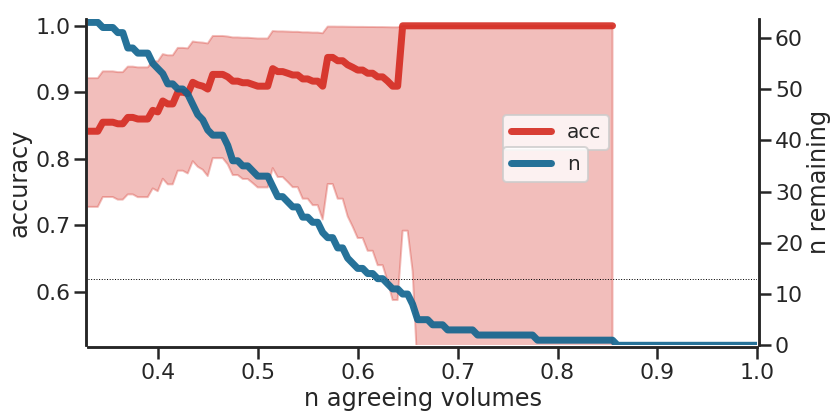

In [40]:
fig = make_ci_plot(conclusive_ci_df,
                   guessing_rate=conclusive_guessing_rate)

#### check: when comparing the accuracy to the lower bound of the 95% CI as the guessing rate, the p-value should be equal or smaller than .05

E.g. computing binomial tests against lower CI-bound as chance.

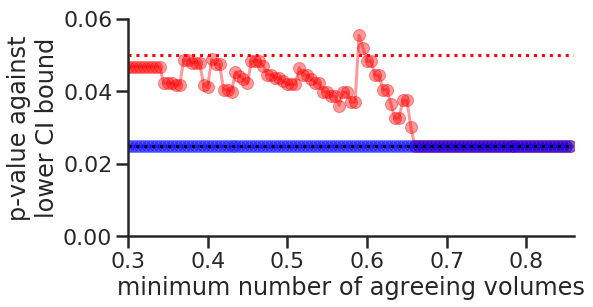

In [41]:
sanity_check_dict = {}
for i in conclusive_ci_df.index:
    
    this_entry = conclusive_ci_df.loc[i]
    
    if not np.isnan(this_entry.acc):
        
        n_correct = this_entry.acc*this_entry.n
        n_total = this_entry.n
        lower_bound = this_entry.ci_low
        
        ts_p = stats.binom_test(n_correct,
                              n=n_total,
                              p=lower_bound,
                              alternative='two-sided' # this is what we want
                             )
        
        os_p = stats.binom_test(n_correct,
                              n=n_total,
                              p=lower_bound,
                              alternative='greater' # one-sided, just as a frame of reference
                             )
            
        sanity_check_dict[i] = {'n':this_entry.n,'p (2-sided)':ts_p, 'p (1-sided)':os_p}

sanity_check_df = pd.DataFrame(sanity_check_dict).T

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(sanity_check_df.index,sanity_check_df['p (2-sided)'],'-o',c='r',alpha=0.4)
ax.plot(sanity_check_df.index,sanity_check_df['p (1-sided)'],'-o',c='b',alpha=0.4)

ax.set_xlim(0.3,0.86)
ax.set_ylim(0,0.06)
ax.set_ylabel('p-value against\nlower CI bound')
ax.set_xlabel('minimum number of agreeing volumes')
ax.axhline(0.05,c='r',linestyle=':')
ax.axhline(0.025,c='k',linestyle=':')
sns.despine()
plt.show()

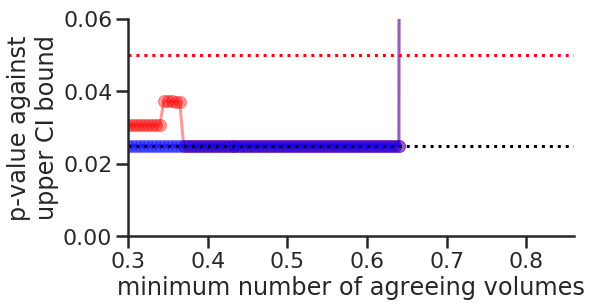

In [42]:
sanity_check_dict = {}
for i in conclusive_ci_df.index:
    
    this_entry = conclusive_ci_df.loc[i]
    
    if not np.isnan(this_entry.acc):
        
        n_correct = this_entry.acc*this_entry.n
        n_total = this_entry.n
        upper_bound = this_entry.ci_high
        
        ts_p = stats.binom_test(n_correct,
                              n=n_total,
                              p=upper_bound,
                              alternative='two-sided' # this is what we want
                             )
        
        os_p = stats.binom_test(n_correct,
                              n=n_total,
                              p=upper_bound,
                              alternative='less' # one-sided, just as a frame of reference
                             )
            
        sanity_check_dict[i] = {'n':this_entry.n,'p (2-sided)':ts_p, 'p (1-sided)':os_p}

sanity_check_df = pd.DataFrame(sanity_check_dict).T

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(sanity_check_df.index,sanity_check_df['p (2-sided)'],'-o',c='r',alpha=0.4)
ax.plot(sanity_check_df.index,sanity_check_df['p (1-sided)'],'-o',c='b',alpha=0.4)

ax.set_xlim(0.3,0.86)
ax.set_ylim(0,0.06)
ax.set_ylabel('p-value against\nupper CI bound')
ax.set_xlabel('minimum number of agreeing volumes')
ax.axhline(0.05,c='r',linestyle=':')
ax.axhline(0.025,c='k',linestyle=':')
sns.despine()
plt.show()

Interpretation: If we test one-sided against the lower bound, we get always .025, and if we test one-sided against the upper bound, we also always get 0.025 (except when the accuracy gets to 1 and the upper bound of the CI can't go higher than one).  
For the two-sided test, the p-values almost always stay right below 0.05.  
Taken together, this seems a good independent check that the CIs which we compute behave as intended.

### with the inclusion of inconclusive cases

In [43]:
withinconclusive_prediction_df = make_metric_df(withinconclusive_proportion_df)
withinconclusive_prediction_df.to_csv('../data/processed/csv/withinconclusive_prediction_df.csv')

withinconclusive_ci_df = make_ci_df(withinconclusive_prediction_df)
withinconclusive_guessing_rate = get_guessing_rate(withinconclusive_prediction_df)

In [ ]:
withinconclusive_prediction_df.loc[draws]

In [45]:
withinconclusive_guessing_rate

0.6145833333333334

In [46]:
withinconclusive_n = withinconclusive_prediction_df.shape[0]
withinconclusive_hits = withinconclusive_prediction_df['hit'].sum()

### compute the point of convergence

In [47]:
# get the difference in accuracies with and without inconclusives
diff_df = pd.DataFrame( abs(withinconclusive_ci_df['acc']-conclusive_ci_df['acc']) )
# sort by index so the first occurence of zero difference comes as the top
diff_df = diff_df[diff_df['acc']==0].sort_index()

In [48]:
diff_df.head()

,acc
0.505,0.0
0.510,0.0
0.515,0.0
0.520,0.0
0.525,0.0


In [49]:
point_of_convergence = diff_df.idxmin().values[-1]
point_of_convergence

0.505

### Figure with both

In [50]:
def make_combined_ci_plot(conclusive_df, withinconclusive_df, marker_list, plt_title=''):

    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    min_vols = 0.335 # indexes up to but not including 0.335 (=>0.340 is the smalles majority possible)
    max_vols = conclusive_df.dropna().iloc[0].name # highest value where there still are data
    
    ax1.plot(
        conclusive_df.loc[max_vols:min_vols,'acc'],
        c=color_dict['red'],
        linewidth=5,
        alpha=0.8,
        clip_on=False)
    ax1.fill_between(
        conclusive_df.index,
        conclusive_df.loc[:,'ci_low'],
        conclusive_df.loc[:,'ci_high'].fillna(1),
        alpha=0.3,
        color=color_dict['red'])

    ax1.plot(
        withinconclusive_df.loc[max_vols:min_vols,'acc'],
        c=color_dict['blue'],
        linewidth=5,
        label=None,
        alpha=0.8,
        clip_on=False)
    ax1.fill_between(
        withinconclusive_df.index,
        withinconclusive_df.loc[:,'ci_low'],
        withinconclusive_df.loc[:,'ci_high'].fillna(1),
        alpha=0.3,
        color=color_dict['blue'])

    ax2 = ax1.twinx()
    ax2.plot(
        conclusive_df.loc[max_vols:min_vols-0.005,'n'], # hack: start a bit earlier because dashed line otherwise starts with blank
        c=color_dict['red'],
        linewidth=5,
        alpha=0.4,
        linestyle=':',
        clip_on=False)
    ax2.plot(
        withinconclusive_df.loc[max_vols:min_vols-0.005,'n'],
        c=color_dict['blue'],
        linewidth=5,
        alpha=0.4,
        linestyle=':',
        clip_on=False)

    ax1.axhline(withinconclusive_guessing_rate, linestyle='-', color=color_dict['blue'], linewidth=3,alpha=0.9)
    ax1.axhline(conclusive_guessing_rate, linestyle='-', color=color_dict['red'], linewidth=3,alpha=0.9)
                                                                            
    ax1.set_ylim(round(withinconclusive_guessing_rate * 0.8, 1), 1.)
    ax1.set_xlabel('proportion of agreeing volumes')
    ax1.set_ylabel('proportion correct')

    n_cases = withinconclusive_df.loc[:, 'n'].max()
    ax2.set_ylim(-0.01, n_cases)
    ax2.set_yticks([0,20,40,60,80,n_cases])
    ax2.set_ylabel(u'n remaining cases')
    
    # cutoff on x-axis

    ax1.set_xlim(0.33,max_vols)
    ax2.set_xlim(0.33,max_vols)
    ax1.set_xticks([0.34,0.5,0.7,max_vols])
    ax2.set_xticks([0.34,0.5,0.7,max_vols])
    ax1.set_xticklabels([0.34,0.5,0.7,np.round(max_vols-0.005,2)]) # start with min possible and end a bit short of the max
    ax2.set_xticklabels([0.34,0.5,0.7,np.round(max_vols-0.005,2)])

    # markers, adapted from farenorth https://stackoverflow.com/a/37494127
    circle_rad = 15
    for count,(x_pos,y_pos) in enumerate(marker_list): 
        ax1.plot(x_pos,y_pos , 'o',
                ms=circle_rad * 2, mec='white', mfc='none', mew=4)
        ax1.annotate(count+1, xy=(x_pos,y_pos), xytext=(circle_rad, circle_rad),
                    textcoords='offset points',
                    color='white', size=30)

    sns.despine(left=False,right=False, trim=True, offset=5)

    # make fake data for legend
    ax2.plot(-10,-10,'o',label='conclusive cases',color=color_dict['red'])
    ax2.plot(-10,-10,'o',label='all cases',color=color_dict['blue'])
    ax2.plot(-10,-10,'-',linewidth=4,label='accuracy',color=color_dict['black'])
    ax2.plot(-10,-10,':',linewidth=4,label='sample size',color=color_dict['black'])
    handles,labels=ax2.get_legend_handles_labels() 
    ax2.legend(handles[2:],labels[2:],loc=(0.62, 0.4), fontsize=20)
    
    plt.suptitle(plt_title)
    plt.savefig('../reports/figures/13-group-acc-ci.png',dpi=300,bbox_inches='tight')
    plt.close()
    return fig

### get the most interesting points

Point where inc is as good as conc:

In [51]:
inc_as_good = (withinconclusive_ci_df.loc[:, 'acc']>=conclusive_ci_df.loc[0.33999999999999997, 'acc'])
withinconclusive_ci_df.loc[inc_as_good].iloc[[-1]]

,acc,n,n_prop,ci_low,ci_high
0.435,0.854545,55.0,0.572917,0.733368,0.935049


In [52]:
# at the point of convergence, pre-selected and non-preselected samples should be the same
assert conclusive_ci_df.loc[point_of_convergence,'acc'] == withinconclusive_ci_df.loc[point_of_convergence, 'acc']

In [53]:
withinconclusive_ci_df.loc[[point_of_convergence],:]

,acc,n,n_prop,ci_low,ci_high
0.505,0.909091,33.0,0.34375,0.756684,0.980845


In [54]:
marker_list = [(0.34, conclusive_ci_df.loc[0.33999999999999997, 'acc']),
               (0.34, withinconclusive_ci_df.loc[0.33999999999999997, 'acc']),
               (point_of_convergence, withinconclusive_ci_df.loc[point_of_convergence, 'acc'])
              ]
marker_list

[(0.34, 0.8412698412698413),
 (0.34, 0.6770833333333334),
 (0.505, 0.9090909090909091)]

In [55]:
fig = make_combined_ci_plot(conclusive_ci_df,
                            withinconclusive_ci_df,
                            marker_list)

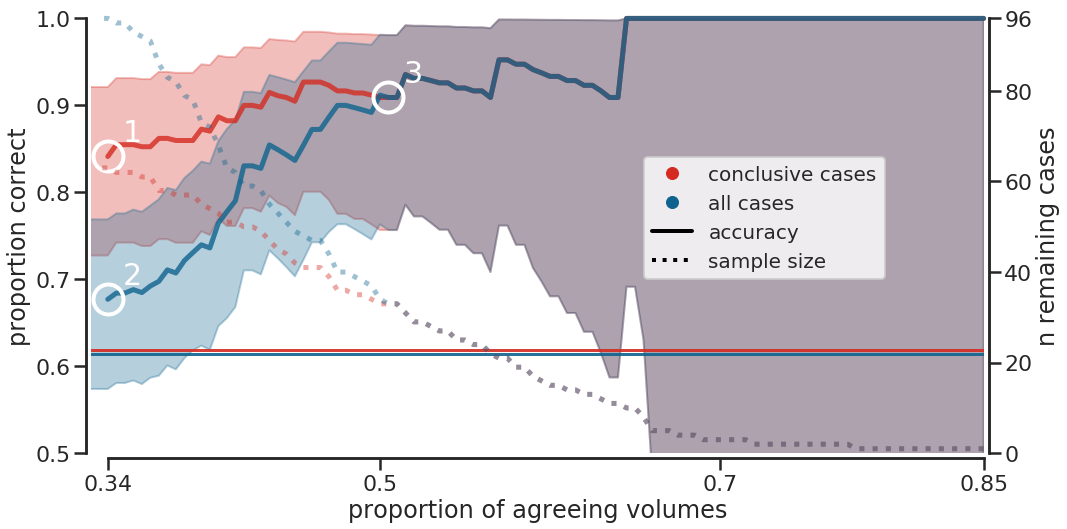

In [56]:
fig

Perfect Accuracy:

In [57]:
is_perfect = withinconclusive_ci_df.loc[:,'acc']>=1
withinconclusive_ci_df.loc[is_perfect,:].iloc[[-1]]

,acc,n,n_prop,ci_low,ci_high
0.645,1.0,10.0,0.104167,0.691503,1.0


Highest number of agreeing volumes (last patient standing):

In [58]:
withinconclusive_ci_df.dropna().iloc[[0]]

,acc,n,n_prop,ci_low,ci_high
0.855,1.0,1.0,0.010417,0.025,1.0


### confusion matrix for full and cutoff data

In [59]:
def make_cm(df,point_of_convergence=point_of_convergence,remove_inc=False,draws=draws):
    
    copy_df = df.copy()
    copy_df = copy_df.rename({
        'highest_class': 'predicted',
        'true_class': 'true'
    },axis=1)

    copy_df.loc[draws, 'predicted'] = 'draw'

    if remove_inc:
        is_below = copy_df.loc[:, 'highest_num'] < point_of_convergence
        copy_df.loc[is_below, 'predicted'] = 'inconclusive'

    cm_df = copy_df.groupby(['true', 'predicted']).count()[['hit']].unstack().fillna(0)['hit']

    if 'bilateral' not in cm_df.columns:
        cm_df.loc[:, 'bilateral'] = 0
      
    cm_df = cm_df.rename({
        'left': 'L',
        'bilateral': 'B',
        'right': 'R',
        'inconclusive': 'INC'
    },axis=1)
    
    cm_df = cm_df.rename({'left': 'L', 'bilateral': 'B', 'right': 'R'}, axis=0)
    
    #if remove_inc:
    cm_df = cm_df.loc[['L', 'B', 'R'], ['L', 'B', 'R', 'INC','draw']]
    #else:
    #    cm_df = cm_df.loc[['L', 'B', 'R'], ['L', 'B', 'R']]
        
    return cm_df

In [60]:
def make_typ_atpy_acc(df):
    
    copy_df = df.copy()
    try:
        copy_df = copy_df.drop('INC',axis=1)
    except:
        pass

    copy_df = copy_df.rename({'L':'typ'},axis=0)
    copy_df = copy_df.rename({'L':'typ'},axis=1)
    copy_df = copy_df.rename({'B':'atyp','R':'atyp'},axis=0)
    copy_df = copy_df.rename({'B':'atyp','R':'atyp'},axis=1)
    copy_df = copy_df.groupby(level=0,axis=0).sum()
    copy_df = copy_df.groupby(level=0,axis=1).sum()
    
    this_cm = copy_df.copy()
    
    correct_preds = this_cm.loc['typ','typ']+this_cm.loc['atyp','atyp']
    all_preds = this_cm.sum().sum()
    
    this_cm_dict = {}
    for i in ['typ','atyp']:
        this_cm_dict[i] = (this_cm.loc[i]/this_cm.loc[i].sum())[i]
        
    this_cm_dict['overall'] = correct_preds/all_preds
    this_cm_df = pd.DataFrame(this_cm_dict,index=['acc']).T
    
    return this_cm_df

In [61]:
conclusive_prediction_df.shape,withinconclusive_prediction_df.shape

((63, 7), (96, 7))

Make confusion matrix

In [62]:
full_conclusive_cm_df = make_cm(conclusive_prediction_df)
full_conclusive_cm_df

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


predicted,L,B,R,INC,draw
true,,,,,
L,38.0,0.0,1.0,NaN,0.0
B,2.0,4.0,4.0,NaN,0.0
R,1.0,1.0,11.0,NaN,1.0


In [63]:
for group in full_conclusive_cm_df.index:
    print('%s %.2f'%(group, full_conclusive_cm_df.loc[group,group]/full_conclusive_cm_df.loc[group].sum()))
    
print('%s %.2f'%('all', np.diagonal(full_conclusive_cm_df).sum()/full_conclusive_cm_df.sum().sum()))

L 0.97
B 0.40
R 0.79
all 0.84


In [64]:
make_typ_atpy_acc(full_conclusive_cm_df).round(2)

,acc
typ,0.97
atyp,0.83
overall,0.92


In [65]:
full_withinconclusive_cm_df = make_cm(withinconclusive_prediction_df)
full_withinconclusive_cm_df

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


predicted,L,B,R,INC,draw
true,,,,,
L,42.0,1.0,16.0,NaN,0.0
B,4.0,4.0,5.0,NaN,1.0
R,1.0,2.0,19.0,NaN,1.0


In [66]:
for group in full_withinconclusive_cm_df.index:
    print('%s %.2f'%(group, full_withinconclusive_cm_df.loc[group,group]/full_withinconclusive_cm_df.loc[group].sum()))
    
print('%s %.2f'%('all', np.diagonal(full_withinconclusive_cm_df).sum()/full_withinconclusive_cm_df.sum().sum()))

L 0.71
B 0.29
R 0.83
all 0.68


In [67]:
make_typ_atpy_acc(full_withinconclusive_cm_df).round(2)

,acc
typ,0.71
atyp,0.81
overall,0.75


In [68]:
cutoff_withinconclusive_cm_df = make_cm(withinconclusive_prediction_df,remove_inc=True)
cutoff_withinconclusive_cm_df

/data/condaEnvs/volumeAnalysis/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


predicted,L,B,R,INC,draw
true,,,,,
L,21.0,0,0.0,38.0,NaN
B,1.0,0,1.0,12.0,NaN
R,1.0,0,9.0,13.0,NaN


In [69]:
make_typ_atpy_acc(cutoff_withinconclusive_cm_df).round(2)

,acc
typ,1.00
atyp,0.83
overall,0.94


### plot all confusion matrices

In [70]:
sns.set_style('dark')

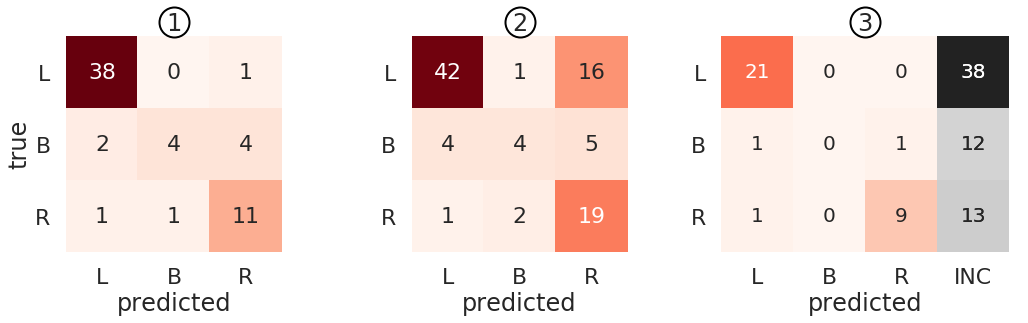

In [71]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_axes([0,1,0.5,0.5])
sns.heatmap(
    full_conclusive_cm_df.drop(['draw','INC'],axis=1),
    square=True,
    annot=True,
    annot_kws={'fontsize':22},
    cmap='Reds',
    cbar=False,
    ax=ax1
)

ax1.plot(1.5,-0.2, 'o', ms=30, mec='k', mfc='none', mew=2,clip_on=False)       
ax1.set_title(1)
plt.yticks(rotation=360)

ax2 = fig.add_axes([0.3,1,0.5,0.5])
sns.heatmap(
    full_withinconclusive_cm_df.drop(['draw','INC'],axis=1),
    square=True,
    annot=True,
    annot_kws={'fontsize':22},
    cmap='Reds',
    cbar=False,
    vmin=0,
    vmax=43,
    ax=ax2
)

ax2.set_ylabel('')
ax2.plot(1.5,-0.2, 'o', ms=30, mec='k', mfc='none', mew=2,clip_on=False)       
ax2.set_title(2)
plt.yticks(rotation=360)


ax3 = fig.add_axes([0.6,1,0.5,0.5])
sns.heatmap(
    cutoff_withinconclusive_cm_df,
    square=True,
    annot=True,
    annot_kws={'fontsize':20},
    cmap='Reds',
    cbar=False,
    vmin=0,
    vmax=43,
    ax=ax3
)

mask = np.concatenate([np.ones([3,3]),np.zeros([3,1])],axis=1)

sns.heatmap(
    cutoff_withinconclusive_cm_df.drop('draw',axis=1),
    square=True,
    annot=True,
    annot_kws={'fontsize':20},
    cmap='Greys',
    cbar=False,
    mask=mask,
    vmin=0,
    vmax=43,
    ax=ax3
)

ax3.set_ylabel('')
ax3.plot(2,-0.2, 'o', ms=30, mec='k', mfc='none', mew=2,clip_on=False)       
ax3.set_title(3)
plt.yticks(rotation=360)

plt.savefig('../reports/figures/13-cms.png',dpi=300,bbox_inches='tight')
plt.show()

### combine into big plot

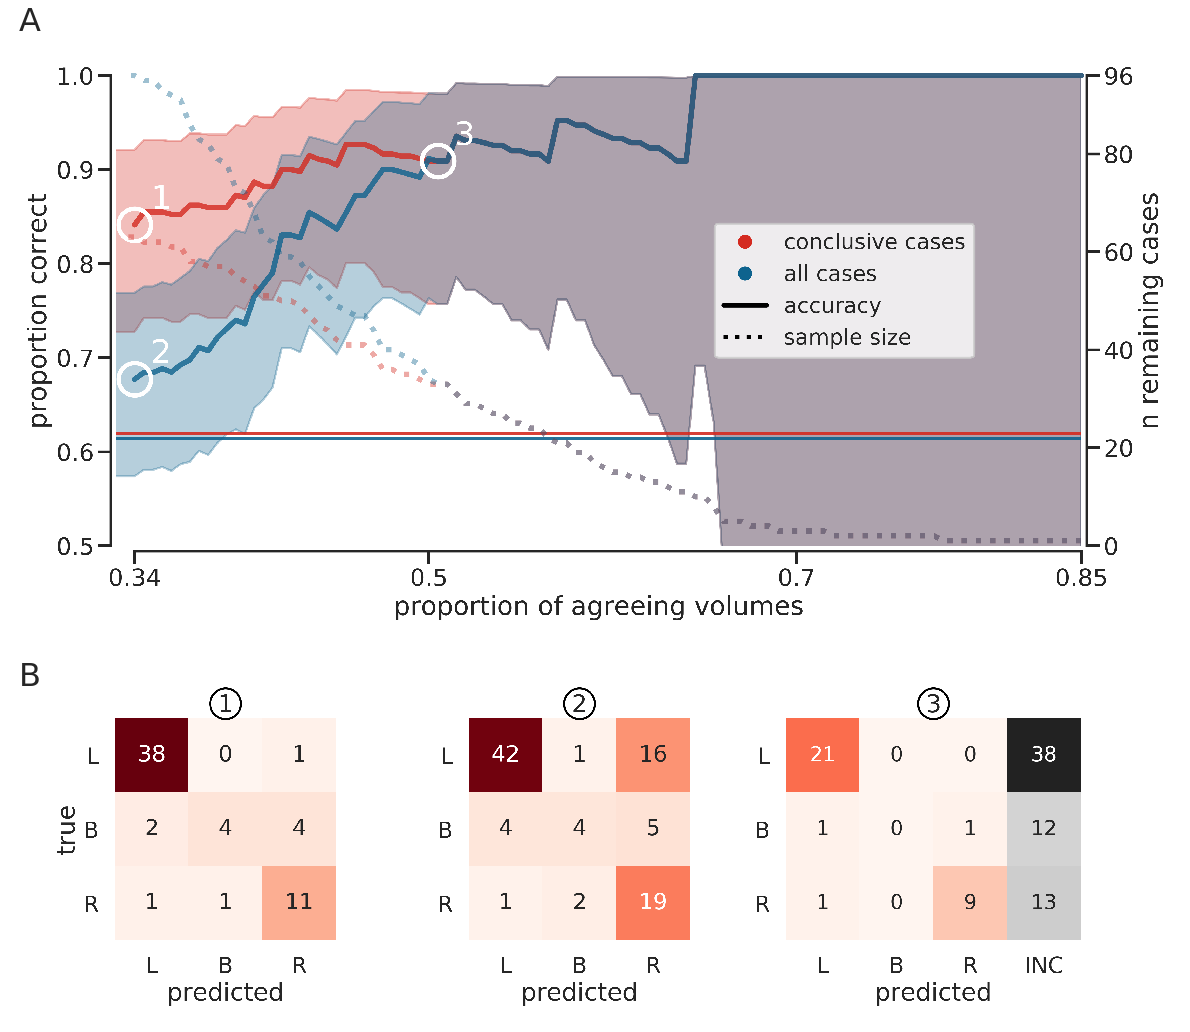

In [72]:
fig = plt.figure(figsize=(16,20))
ax1 = fig.add_axes([0, 1, 1, 1.], xticklabels=[], yticklabels=[])
ax1.imshow(Image.open('../reports/figures/13-group-acc-ci.png'))

ax2 = fig.add_axes([0.025, 0.65, 0.905, 1], xticklabels=[], yticklabels=[])
ax2.imshow(Image.open('../reports/figures/13-cms.png'))

plt.text(0,1.05, 'A',transform=ax1.transAxes, fontsize=32)
plt.text(0,-0.1, 'B',transform=ax1.transAxes, fontsize=32)

plt.savefig('../reports/figures/13-curve-and-cm-together.png',dpi=300,bbox_inches='tight')
plt.show()

### summary

The results show that overall high accuracies can be reached, that both left- and right-lateralized patients can be diagnosed with high hit rates (bilateral patients not so much), and that (i) accuracies increase as the number of agreeing volumes increases and (ii) using the number of agreeing volumes can allow to identify those cases where a correct decision will be more likely.



**************

< [Previous](12-mw-make-correlation-plots-time.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](14-mw-prediction-space.ipynb)